Data Exploration - Business Only until now

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise import Dataset, Reader, NormalPredictor, KNNBasic, KNNWithZScore, KNNWithMeans, KNNWithZScore, SVD
from surprise.model_selection import train_test_split, cross_validate
from collections import defaultdict
from surprise import accuracy
import ast

df_dict = {}
datasets = ['business', 'review', 'user'] #'checkin',  'tip',

for i in datasets:
    df = pd.read_csv(f'yelp_academic_dataset_{i}.csv')
    df_dict[f'df_{i}'] = df

df_business = df_dict['df_business']
df_user = df_dict['df_user']
df_review = df_dict['df_review']

print(df_business.head())

In [ ]:
# df_check = pd.read_csv('yelp_academic_dataset_checkin.csv')
# df_tip = pd.read_csv('yelp_academic_dataset_tip.csv')

In [7]:
nulls = pd.DataFrame(df_business.isna().sum(), columns=['null_count'])
print(nulls)

              null_count
business_id            0
name                   0
address             5127
city                   0
state                  0
postal_code           73
latitude               0
longitude              0
stars                  0
review_count           0
is_open                0
attributes         13744
categories           103
hours              23223


There are some places without categorie. Delete them or Fill it based on their reviews...

In [17]:
from collections import Counter
from nltk import word_tokenize

#tokens = df_business["categories"].apply(lambda x: word_tokenize(str(x))) #[(',', 518349), ('&', 108359), ('Services', 56156), ('Restaurants', 52343), ('Food', 43813), ('Shopping', 24858), ('Home', 24169), ('Bars', 21022), ('Spas', 17070), ('Beauty', 15836)]
 #i will not use this, because i want to keep merged the categories like 'X & Y'

categories_split = df_business["categories"].apply(lambda x: [cat.strip() for cat in str(x).split(',')])
all_categories = [category for sublist in categories_split for category in sublist]
category_counter = Counter(all_categories)  #use Counter

print("Nº of categories: ", len(category_counter))


Nº of categories:  1312


Maybe we should use only top X categories, otherwise it's too sparse

[('Restaurants', 52268), ('Food', 27781), ('Shopping', 24395), ('Home Services', 14356), ('Beauty  and  Spas', 14292), ('Nightlife', 12281), ('Health  and  Medical', 11890), ('Local Services', 11198), ('Bars', 11065), ('Automotive', 10773)]


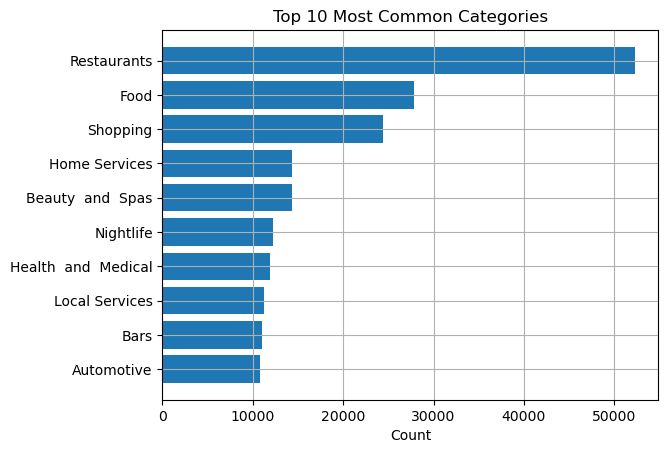

In [18]:
most_common_categories = category_counter.most_common(10)
print(most_common_categories)  

categories, counts = zip(*most_common_categories)

plt.figure()
plt.barh(categories, counts)
plt.xlabel('Count')
plt.title('Top 10 Most Common Categories')
plt.gca().invert_yaxis() 
plt.grid()
plt.show()

In [19]:
df_business = df_business[df_business["is_open"] == 1]
# df_business = businesses_df[(businesses_df['city'] == 'Philadelphia') & (businesses_df['categories'].str.contains('Restaurants', na=False))].reset_index(drop=True)

In [42]:
restaurants_df = df_business[df_business["categories"].str.contains('Restaurants', na=False)]
# print(restaurants_df.head())


In [32]:
pd.set_option('display.max_colwidth', 150)
print(restaurants_df[['attributes']].head(20))

                                                                                                                                               attributes
3   {'RestaurantsDelivery': 'False', 'OutdoorSeating': 'False', 'BusinessAcceptsCreditCards': 'False', 'BusinessParking': "{'garage': False, 'street':...
5   {'BusinessParking': 'None', 'BusinessAcceptsCreditCards': 'True', 'RestaurantsAttire': "u'casual'", 'OutdoorSeating': 'True', 'RestaurantsReservat...
9   {'RestaurantsAttire': "'casual'", 'RestaurantsGoodForGroups': 'False', 'BusinessAcceptsCreditCards': 'True', 'OutdoorSeating': 'True', 'GoodForKid...
11  {'Alcohol': "'none'", 'OutdoorSeating': 'None', 'RestaurantsReservations': 'False', 'Ambience': "{'touristy': False, 'hipster': False, 'romantic':...
12  {'RestaurantsReservations': 'False', 'RestaurantsTakeOut': 'True', 'RestaurantsAttire': "'casual'", 'GoodForKids': 'True', 'BikeParking': 'False',...
15  {'RestaurantsReservations': 'True', 'RestaurantsGoodForGroups': 'True', 

I would suggest to convert the main categories into new features 
For now, I will convert them in a dictionary to be simple to filter and analyze

In [ ]:
restaurants_df = df_business[df_business["categories"].str.contains('Restaurants', na=False)]

restaurants_df['attributes'] = restaurants_df['attributes'].fillna('{}') # fill NaN values with empty dictionaries
restaurants_df['attributes'] = restaurants_df['attributes'].apply(ast.literal_eval) # from string representations into  dicionaries

# Filter restaurants that offer delivery
delivery_restaurants = restaurants_df[restaurants_df['attributes'].apply(lambda x: x.get('RestaurantsDelivery') == 'True')]

In [49]:
df_business['delivery'] = restaurants_df['attributes'].apply(lambda x: x.get('RestaurantsDelivery') == 'True')

# Fill NaN values in the new 'delivery' column with False (for non-restaurants)
df_business['delivery'] = df_business['delivery'].fillna(False)

# Display the first 10 rows of the updated DataFrame
print(df_business[['name', 'delivery']].head(10))

                        name  delivery
1              The UPS Store     False
3         St Honore Pastries     False
4   Perkiomen Valley Brewery     False
5             Sonic Drive-In      True
6            Famous Footwear     False
7             Temple Beth-El     False
9             Sonic Drive-In      True
10                 Marshalls     False
11     Vietnamese Food Truck     False
12                   Denny's      True


C:\Users\asus\AppData\Local\Temp\ipykernel_4728\1947569722.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_business['delivery'] = restaurants_df['attributes'].apply(lambda x: x.get('RestaurantsDelivery') == 'True')
C:\Users\asus\AppData\Local\Temp\ipykernel_4728\1947569722.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_business['delivery'] = df_business['delivery'].fillna(False)
C:\Users\asus\AppData\Local\Temp\ipykernel_4728\1947569722.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

And do the same for 'Categories'?

In [33]:
print(restaurants_df[['categories']].head(20))


                                                                                                           categories
3                                                           Restaurants, Food, Bubble Tea, Coffee  and  Tea, Bakeries
5                                    Burgers, Fast Food, Sandwiches, Food, Ice Cream  and  Frozen Yogurt, Restaurants
9                                                Ice Cream  and  Frozen Yogurt, Fast Food, Burgers, Restaurants, Food
11                                                                         Vietnamese, Food, Restaurants, Food Trucks
12                                                American (Traditional), Restaurants, Diners, Breakfast  and  Brunch
15                                                                                  Sushi Bars, Restaurants, Japanese
19                                                                                                Korean, Restaurants
22                                                      

Observações:
* Há atributos repetidos: como 'None' e 'none'


In [ ]:
#criar atributo que indica se está aberto ao fim de semana